In [1]:
import torch
import torch.nn as nn
import torchvision
import numpy as np
import sys
import matplotlib.pyplot as plt
sys.path.append('..')
import condense
condense.logger.setLevel("INFO")

data = torchvision.datasets.MNIST('datasets',
                                  train=True,
                                  download=True, 
                                  transform=torchvision.transforms.ToTensor())
test = torchvision.datasets.MNIST('datasets',
                                  train=False,
                                  download=True, 
                                  transform=torchvision.transforms.ToTensor())
loader = torch.utils.data.DataLoader(data,
                                     batch_size=200,
                                     shuffle=True)
eval_loader = torch.utils.data.DataLoader(test,
                                         batch_size=100,
                                         shuffle=True)

# Model Definition

In [2]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.layer1 = nn.Conv2d(in_channels=1, out_channels=4, kernel_size=4, stride=2)
        self.layer2 = nn.Conv2d(in_channels=4, out_channels=2, kernel_size=2)
        self.dense = nn.Linear(288, out_features=50)
        self.output = nn.Linear(50, out_features=10)
    

    def forward(self, X):
        X = self.layer1.forward(X)
        X = self.layer2.forward(torch.relu(X))
        X = X.view(torch.relu(X).size(0), -1)
        X = self.dense.forward(torch.relu(X))
        X = self.output.forward(torch.relu(X))
        X = torch.log_softmax(X, 1)
        return X
    
    def train(self, d):
        criterion = nn.CrossEntropyLoss()
        optim = torch.optim.SGD(self.parameters(), lr=0.1, weight_decay=0)
        
        for i, (X, y) in enumerate(d):
            self.zero_grad()
            pred = self.forward(X)
            l = criterion(pred, y)
            l.backward()
            optim.step()
            if i % 100 == 0:
                print('Training Loss:', float(l))
            
net = Network()

# Apply `PruningAgent` module to your model


As we can see, no pruning has happened yet and all sparsity masks are initialized to `1`.

In [3]:
pruned = condense.torch.PruningAgent(net, 
                                     condense.optimizer.sparsity_functions.Constant(0.8), 
                                     apply_mask=False,                   # Don't generate & apply masks on initialization
                                     ignored_params=[net.output]         # We don't want to keep the output layer unpruned
                                    )   
f'Parameter Sparsity: {pruned.get_parameter_sparsity()}'

'Parameter Sparsity: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]'

# Start the ticket search process
The ticket search process is training operation agnostic, so you are free to use whatever you like to train your model.
On `TicketSearch` entry all model parameters get saved for reinitialization later on.
On exit, parameters get reinitialized to their original values and masks get applied.

In [4]:
with condense.torch.TicketSearch(pruned):
    pruned.model.train(loader)  
    
f'Parameter Sparsity: {pruned.get_parameter_sparsity()}'    

Training Loss: 2.309466600418091
Training Loss: 2.2541565895080566
Training Loss: 0.4554315507411957


'Parameter Sparsity: [0.8125, 1.0, 0.8125, 1.0, 0.8000694444444445, 0.82, 0.0, 0.0]'

# Start the actual training on the pruned model

Training Loss: 2.293887138366699
Training Loss: 0.33976197242736816
Training Loss: 0.2904224097728729

Parameter Sparsity: [0.8125, 1.0, 0.8125, 1.0, 0.8000694444444445, 0.82, 0.0, 0.0]


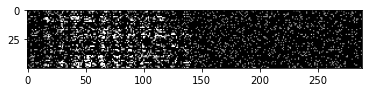

In [5]:
pruned.model.train(loader) 
print(f'\nParameter Sparsity: {pruned.get_parameter_sparsity()}') 
plt.imshow(np.abs(pruned.model.dense.weight.detach().numpy()), vmin=0, vmax=.1, cmap='gist_gray')